In [1]:
import os
import os.path as path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps


In [2]:
# 1. Generate random V1 weights

numCell = 100
dim = (30, 30)
cellSize = 5
sparseFreq = 3

W = V1_weights(numCell, dim, cellSize, sparseFreq)

In [3]:
print(W.shape)

(100, 900)


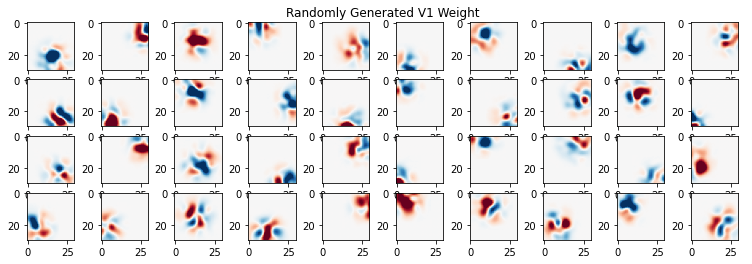

In [4]:
# 2. Plot those V1 weights

fig = plt.figure(figsize = (13, 4))
plt.title('Randomly Generated V1 Weight')
plt.axis('off')
for i in range(40):
    ax = fig.add_subplot(4, 10, i+1)
    cell_rf = W[i]
    cell_rf = cell_rf.reshape(dim)
    plt.imshow(cell_rf, cmap="RdBu")
    plt.clim([-3, 3])
    #plt.axis('off')

In [5]:
W.shape

(100, 900)

In [6]:
# Wx = (lambda)Ux * G
# min ||y-G(Lambda)s||^2 + lambda||s||.

In [7]:
# load size dim image
# reshape to dim[0] * dim[1]
# do:
#W @ x

(64, 104)


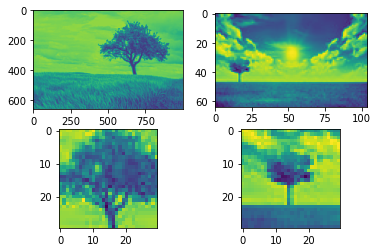

In [8]:
fig = plt.figure()

img_Original1 = Image.open("image/tree.jpg") # Original size(1000, 662)
img_Original1 = ImageOps.grayscale(img_Original1)

img_Original2 = Image.open("image/tree3.jpg") # Original size(64, 104)
img_Original2 = ImageOps.grayscale(img_Original2)
print(np.asarray(img_Original2).shape)

# took 30 X 30 pixel part of tree image at about coord(650, 260)
img1 = Image.open("image/tree_part1.jpg")
img1 = ImageOps.grayscale(img1)
imgArr1 = np.asarray(img1)


# Substitution image in case
img2 = Image.open("image/tree3_part.jpg")
img2 = ImageOps.grayscale(img2)
imgArr2 = np.asarray(img2)

# # of image
numImage = 2

#Show image
ax = fig.add_subplot(2, 2, 1)
plt.imshow(img_Original1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img_Original2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(img2)

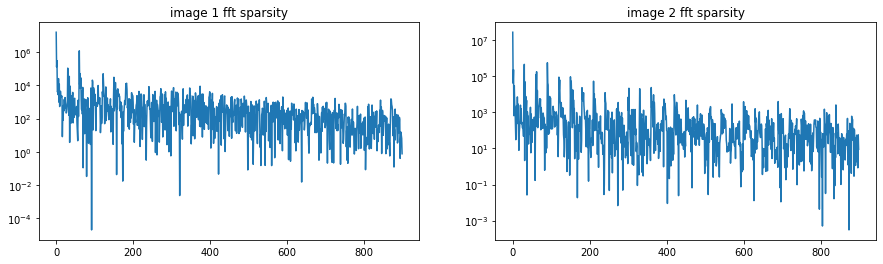

In [9]:
fig = plt.figure(figsize = (15, 4))

# FFT of original image
ax = fig.add_subplot(1, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho', axes=[0,1]).ravel() ** 2)
plt.title("image 1 fft sparsity")
ax.set_yscale('log')

ax = fig.add_subplot(1, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho', axes=[0,1]).ravel() ** 2)
plt.title("image 2 fft sparsity")
ax.set_yscale('log')

In [10]:
n = 30 # image in (n, n) dimension

imgArr1 = imgArr1.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
imgArr2 = imgArr2.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
print("ImgArr shape: ", imgArr1.shape)

ImgArr shape:  (900, 1)


Text(0.5, 1.0, 'image 2 fft sparsity')

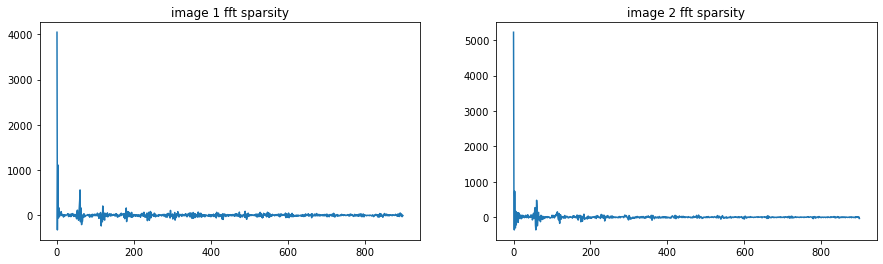

In [11]:
fig = plt.figure(figsize = (15, 4))

# FFT of original image
ax = fig.add_subplot(1, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho'))
plt.title("image 1 fft sparsity")

ax = fig.add_subplot(1, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho'))
plt.title("image 2 fft sparsity")

### Seems like it is sparse enough, Thus I will try to implement original fft onto it to see if it can generate original image

## From y = CΨs, (While considering W ~= C
#### 1.Get y
#### 2. Do WΨ to get theta
#### 3. Lasso to fit thetha with y and get sparse s
#### 4. Reconstruct image

In [12]:
# 1. Some measurement y

# image 1
y1 = W @ imgArr1
y1 = y1.squeeze()

# image 2
y2 = W @ imgArr2
y2 = y2.squeeze()

In [13]:
## 2. WΨ
theta = fft.dctn(W.reshape(numCell, n, n), norm = 'ortho', axes = [1, 2])
theta = theta.reshape(numCell, n*n)
theta.shape


(100, 900)

In [14]:
# Check difference between W and theta
#fig = plt.figure(figsize = (15, 4))
#ax = fig.add_subplot(1, 2, 1)
#plt.plot(theta)
#plt.title("Theta")

#ax = fig.add_subplot(1, 2, 2)
#plt.plot(W)
#plt.title("W")


s1 shape: (900,)
s2 shape: (900,)


Text(0.5, 1.0, 'sparse s2')

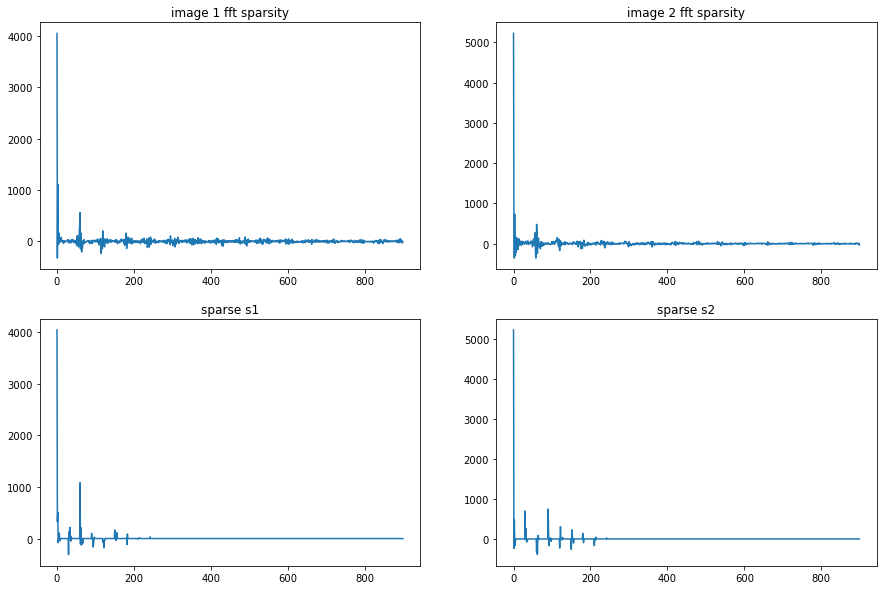

In [15]:


fig = plt.figure(figsize = (15, 10))

# FFT of original image
ax = fig.add_subplot(2, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho'))
plt.title("image 1 fft sparsity")

ax = fig.add_subplot(2, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho'))
plt.title("image 2 fft sparsity")

# Normalize data with lasso
mini = Lasso(alpha = 1*numCell)
mini.fit(theta, y1)
s1 = mini.coef_
print("s1 shape:", s1.shape)

ax = fig.add_subplot(2, 2, 3)
plt.plot(s1)
plt.title('sparse s1')

mini.fit(theta, y2)
s2 = mini.coef_
print("s2 shape:", s2.shape)

ax = fig.add_subplot(2, 2, 4)
plt.plot(s2)
plt.title('sparse s2')

In [16]:
# 4. Reform image
reform1 = fft.idctn(s1.reshape(n, n), norm='ortho')
reform2 = fft.idctn(s2.reshape(n, n), norm='ortho')

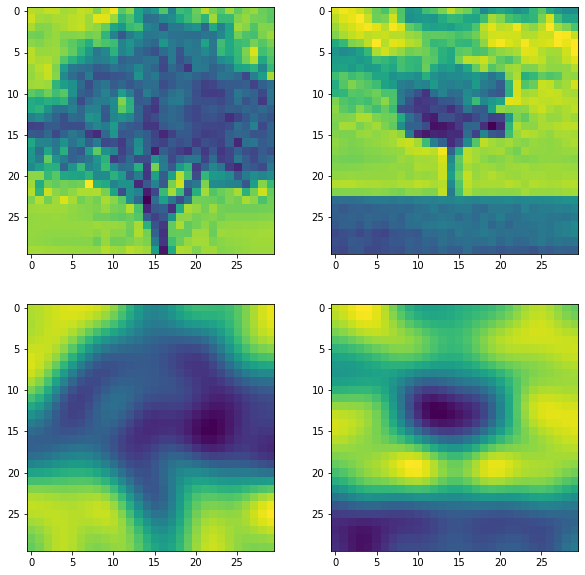

In [17]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(reform1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(reform2)

In [18]:
np.linalg.norm(img1 - reform1, 'fro') / n

25.18773846855242

In [19]:
130303

130303

In [20]:
imgArr1

array([[213],
       [210],
       [216],
       [216],
       [206],
       [208],
       [216],
       [214],
       [193],
       [216],
       [233],
       [178],
       [196],
       [141],
       [117],
       [134],
       [176],
       [112],
       [167],
       [160],
       [186],
       [213],
       [190],
       [177],
       [203],
       [182],
       [195],
       [202],
       [185],
       [180],
       [220],
       [206],
       [204],
       [208],
       [208],
       [214],
       [215],
       [204],
       [228],
       [227],
       [203],
       [159],
       [174],
       [142],
       [ 93],
       [ 95],
       [115],
       [122],
       [144],
       [163],
       [181],
       [158],
       [205],
       [163],
       [165],
       [193],
       [201],
       [190],
       [187],
       [179],
       [207],
       [195],
       [196],
       [203],
       [207],
       [214],
       [216],
       [204],
       [199],
       [184],
       [145],
      

In [21]:
reform1

array([[198.95807703, 200.89412888, 203.98001504, 207.10463063,
        209.42225543, 210.6449668 , 210.82732691, 209.8169497 ,
        206.82626306, 200.55019352, 189.90628865, 175.02172995,
        157.83610497, 141.82130681, 130.79188814, 127.32133041,
        131.5635342 , 141.11972651, 152.06477827, 160.64707463,
        164.83818267, 165.0121017 , 163.50281783, 163.3481701 ,
        166.8747551 , 174.75755212, 185.86486659, 197.79517252,
        207.75273603, 213.38900864],
       [198.22225141, 200.40742914, 203.79345603, 206.96022051,
        208.78201678, 208.85660345, 207.36715438, 204.51617276,
        199.98769578, 192.89987784, 182.38515427, 168.48410218,
        152.76098506, 138.14310491, 127.91786617, 124.33680415,
        127.55694258, 135.51390206, 144.83604298, 152.35291349,
        156.44334738, 157.57646026, 157.84435046, 159.80204444,
        165.23139476, 174.39363003, 186.0078963 , 197.81327069,
        207.35518068, 212.6624144 ],
       [197.67641603, 200.1313

In [22]:
np.linalg.svd(theta)

(array([[-0.10419734,  0.07178554, -0.41286491, ..., -0.03547882,
         -0.10209072, -0.01303554],
        [-0.01640177, -0.00823671, -0.01307459, ...,  0.02426326,
          0.00983514,  0.02174246],
        [ 0.33234624,  0.13047965, -0.11131499, ..., -0.09244773,
          0.06121255, -0.08892326],
        ...,
        [ 0.01061255,  0.00372144,  0.04275369, ...,  0.05402756,
         -0.135598  ,  0.00191732],
        [ 0.04115772, -0.11896088,  0.07141761, ..., -0.02358113,
          0.09691833, -0.03889953],
        [-0.02268255, -0.00315153, -0.04129893, ...,  0.05550248,
         -0.14939127,  0.09845764]]),
 array([78.90706198, 76.06246262, 74.29531067, 69.15380786, 65.05123744,
        60.69524358, 57.53610293, 54.14614333, 49.8220503 , 47.83989558,
        47.76500147, 46.14931013, 44.33645655, 43.71726215, 40.97052524,
        38.06327348, 36.90981475, 36.16670188, 34.0478125 , 33.52524247,
        32.00585064, 30.07685807, 29.81419477, 28.86748499, 27.77041885,
        

In [23]:
theta.shape

(100, 900)